In [182]:
import numpy as np
from scipy import ndimage
from PIL import Image
from scipy.ndimage.filters import convolve
import cv2
from scipy import misc
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [183]:
def disp(img):
    display(Image.fromarray(np.asarray(img,'uint8')))

### CANNY EDGE DETECTOR

There are two generic approaches to edge detections in images:
- local extrema of a first derivative operator
- zero crossings of a second derivative operator

The **Canny Edge Detector** is the first type of edge detection algorithm. 
It provides good detection (very less false positives/negatives), good localization (edges found are as close to true image edges as possible) and it minimizes the number of edge pixels around an edge.


We are only going to be working with grayscale images so whatever image we load must be converted to grayscale. Now there are a number of ways to do that. We use the YUV to grayscale encoding scheme as mentioned here : https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/

Let's load in an image and convert it to grayscale to see how it looks

In [184]:
# Method to convert to grayscale
def grayscale(img):
    r, g, b = img[:,:,0],img[:,:,1],img[:,:,2]
    res = 0.299*r + 0.587*g + 0.114*b
    return res

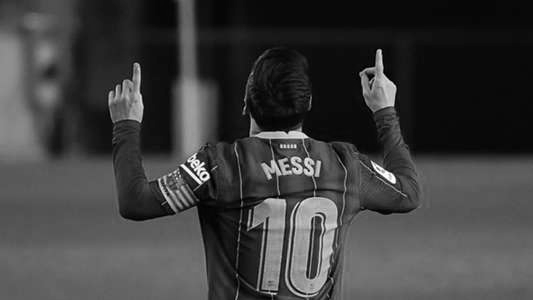

In [186]:
img = cv2.imread('Messi.jpeg')
img = grayscale(img)
disp(img)

Every image has a lot of noise in it. Smoothening the image before taking the derivatives will make it a lot easier to detect edges in images. We smooth the image using Gaussian filters.

In [187]:
def smooth(img, sigma = 1.5):
    return ndimage.gaussian_filter(img,sigma)

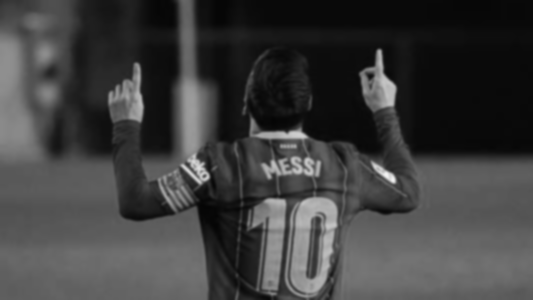

In [189]:
img_smooth = smooth(img,1.2)
disp(img_smooth)

After smoothening the image $I(x,y)$, we find the partial derivatives $I_x(x,y)$ and $I_y(x,y)$ by convolving the Sobel filters with the image.

$G_x = \begin{bmatrix} 1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{bmatrix}$ and $G_y = \begin{bmatrix} 1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\
\end{bmatrix}$

$I_x = G_x * I(x,y)$ and $I_y = G_y * I(x,y)$ where $*$ is the convolution operator.

The gradient intensity matrix $G$ and the gradient direction matrix $\Theta$ are calculated in following ways : 
- $G(i,j) = \sqrt{I_x(i,j)^2 + I_y(i,j)^2}$

- $\Theta(i,j) = \tan^{-1}\left(\dfrac{I_y(i,j)}{I_x(i,j)}\right)$

Note : $\Theta(i,j) \in (-\pi/2, \pi/2)$



In [190]:
def sobel_filtering(img):
    # Sobel filters
    G_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], np.float32)
    G_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    # Partial derivatives
    I_x = ndimage.convolve(img, G_x)
    I_y = ndimage.convolve(img, G_y)
    
    # Gradient intensity matrix
    G = np.sqrt(I_x**2 + I_y**2)
    G *= 255/G.max()
    # Gradient direction matrix
    theta = np.arctan2(I_y,I_x)     
    return G, theta

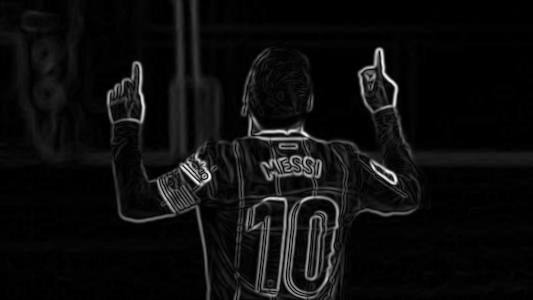

In [191]:
G,theta = sobel_filtering(img_smooth)
disp(G)

As we can see, applying Sobel filters gives us the edges but the edges are not uniform. They don't have a consistent thickness. Because of this, we have to apply an edge thinning algorithm. **Non-maximum suppression** (or Lower bound cut-off suppression) does exactly that. The algorithm for each pixel in the gradient image is : 
1. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions.

2. If the edge strength of the current pixel is the largest compared to the other pixels in the mask with the same direction (e.g., a pixel that is pointing in the y-direction will be compared to the pixel above and below it in the vertical axis), the value will be preserved. Otherwise, the value will be suppressed.

(Taken from - https://en.wikipedia.org/wiki/Canny_edge_detector) 

In [192]:
def nonMax(img,theta):
    pi = np.pi
    res = np.zeros(img.shape)
    A = img
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            
            # Angle is 90 degrees
            if theta[i][j] > 3*pi/8 or theta[i][j] < -3*pi/8:
                n1, n2 = A[i+1,j], A[i-1,j]
            
            # Angle is 45 degrees
            elif pi/8 < theta[i][j] <= 3*pi/8:
                n1, n2 = A[i-1,j+1], A[i+1,j-1]
                
            # Angle is 0 degrees
            elif -pi/8 < theta[i][j] <= pi/8:
                n1, n2 = A[i,j+1], A[i,j-1]
                
            # Angle is -45 degrees
            elif -3*pi/8 < theta[i][j] <= -pi/8:
                n1, n2 = A[i+1,j+1], A[i-1,j-1]
                
            if n1 <= img[i][j] and n2 <= img[i][j]:
                res[i][j] = img[i][j]
            else:
                res[i][j] = 0
                
    return res

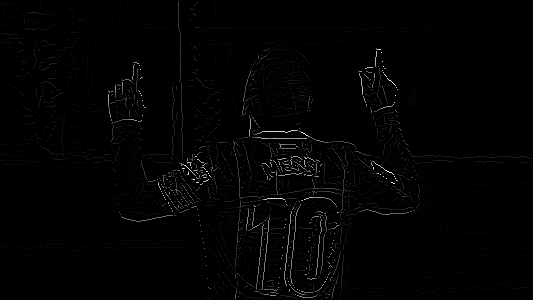

In [196]:
img_nonMax = nonMax(G,theta)
disp(img_nonMax)

The result of non-maximum suppression (NMS) is nearly the same as of Sobel operator, except for the thinner edges. Now, even after performing non-maximum suppression, there remain pixel values that are caused by noise and colour variation. To remove these, we identify pixels on the gradient intensity matrix after NMS and classify each pixel according to two threshold values $K_{\textrm{high}}$ and $K_{\textrm{low}}$.

If a pixel value is greater than or equal to $K_{\textrm{high}}$, we classify it as 'strong' and give it a value of $255$. If a pixel value is less than $K_{\textrm{low}}$, we classify it as 'irrelevant' and give it a value of $0$. If a pixel value is between $K_{\textrm{low}}$ $K_{\textrm{high}}$, we classify it as 'weak' and give it a value of $100$

After thresholding, we iterate over all pixel values and for every 'weak' pixel found, we check the 8 neighbours around it and if even a single one of them is 'strong', then we classify the pixel as 'strong' as well. Else, we give it a value of $0$ and disregard it. This is called **edge tracking by hysteresis**

In [228]:
def thresholding(img):
    high_threshold = img.max()*0.17
    low_threshold = high_threshold/20
    
    res = np.zeros(img.shape)
    res[img >= high_threshold] = 255
    res[img < low_threshold] = 0
    res[(img >= low_threshold) & (img < high_threshold)] = 100
    
    return res


def hysteresis(img):
    M,N = img.shape
    for i in range(1,M-1):
        for j in range(1,N-1):
            if img[i,j] == 100:
                window = img[i-1:i+2, j-1:j+2]
                if 255 in window:
                    img[i,j] = 255
                else:
                    img[i,j] = 0
    return img                

In [229]:
img_thres = thresholding(img_nonMax)
final_img = hysteresis(img_thres)

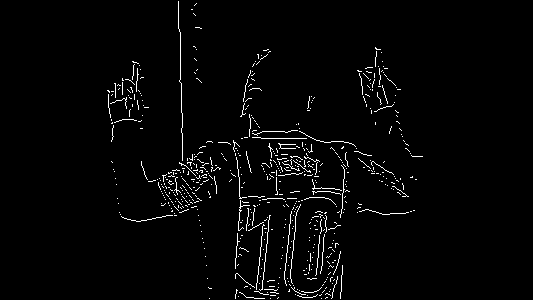

In [230]:
disp(final_img)

In [231]:
def edge_detect(img):
    if len(img.shape) == 3:
        img = grayscale(img)
        
    img_smooth = smooth(img)
    G, theta = sobel_filtering(img_smooth)
    img_nonMax = nonMax(G, theta)
    img_thres = thresholding(img_nonMax)
    final_img = hysteresis(img_thres)
    disp(final_img)

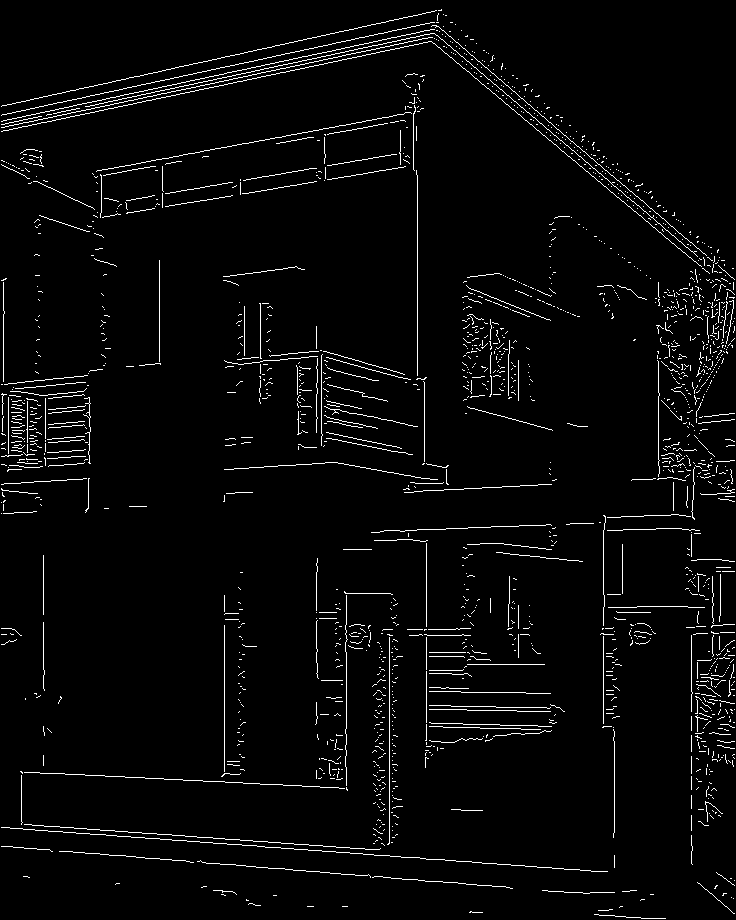

In [232]:
edge_detect(cv2.imread('house.jpeg'))